In [1]:
%matplotlib inline
import pickle
import numpy as np
import matplotlib.pyplot as plt

from model import lorenz63_fdm
from assimilation import Hybrid3DEnVar

In [2]:
X_nature = np.load('./data/X_nature.npy')
X_ini = np.load('./data/X_ini.npy')
ts = np.load('./data/time_span.npy')
Pb = np.load('./data/Pb.npy')
R = np.load('./data/R.npy')

dt = 0.01

# generate initial ensemble
N_ens = 30
rng = np.random.RandomState(42)
X_ens_ini = rng.multivariate_normal(X_ini.ravel(), Pb, size=N_ens).T  # (3, N_ens)

In [3]:
def RMSE(forecast, nature):
    return np.sqrt(np.mean((forecast-nature)**2, axis=0))

# Assimilate normal observation

#### `rmse_hy` as CNTL in the later experiments

In [4]:
# normal observation
X_obs = np.load('./data/obs_normal.npy')

In [7]:
hy = Hybrid3DEnVar(lorenz63_fdm, dt)
hy.list_params()
params = {
    'X_ini': X_ini,
    'X_ens_ini': X_ens_ini,
    'obs': X_obs,
    'obs_interv': 8,
    'Pb': Pb,
    'R': R,
    'H_func': lambda arr: arr,
    'H': np.eye(3),
    'alpha': 0.2,
    'inflat': 1.6,
    'beta': 0.5
}
hy.set_params(**params)
hy.cycle()

0.8931456007445371


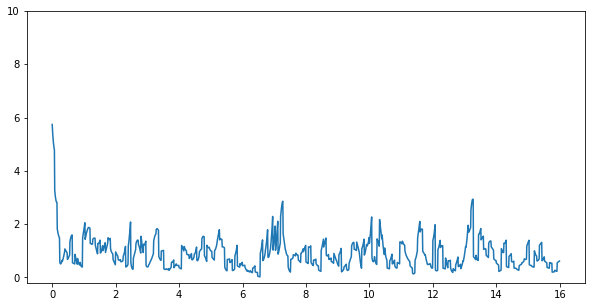

In [8]:
rmse_hy = RMSE(hy.analysis_3dvar, X_nature)

plt.figure(figsize=(10, 5))
plt.plot(ts, rmse_hy)
plt.ylim([-0.2, 10])
print(rmse_hy.mean())

# First moment

### Assimilate bias observations based on normality test

In [10]:
# first moment
ex_obs_dict = pickle.load(open('./data/obs_bias_005_040.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.05', '0.15', '0.20', '0.25', '0.30', '0.35', '0.40'])

obsm=0.05, Mean RMSE=0.8736, Variance RMSE=0.2849,  Without spinup: Mean RMSE=0.8352, Variance RMSE=0.1928
obsm=0.15, Mean RMSE=0.9644, Variance RMSE=0.3652,  Without spinup: Mean RMSE=0.9082, Variance RMSE=0.2367
obsm=0.20, Mean RMSE=0.9070, Variance RMSE=0.3593,  Without spinup: Mean RMSE=0.8634, Variance RMSE=0.2245
obsm=0.25, Mean RMSE=0.9111, Variance RMSE=0.3398,  Without spinup: Mean RMSE=0.8704, Variance RMSE=0.2246
obsm=0.30, Mean RMSE=0.9881, Variance RMSE=0.4148,  Without spinup: Mean RMSE=0.9433, Variance RMSE=0.2797
obsm=0.35, Mean RMSE=1.0178, Variance RMSE=0.4524,  Without spinup: Mean RMSE=0.9751, Variance RMSE=0.3330
obsm=0.40, Mean RMSE=1.0506, Variance RMSE=0.5310,  Without spinup: Mean RMSE=1.0132, Variance RMSE=0.4484


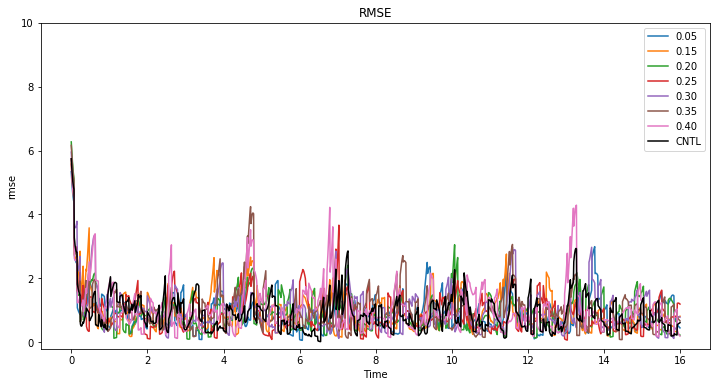

In [11]:
plt.figure(figsize=(12, 6))

mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

for obsm in ex_obs_dict.keys():
    obs = ex_obs_dict[obsm]

    hy = Hybrid3DEnVar(lorenz63_fdm, dt)
    hy.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.2,
        'inflat': 1.6,
        'beta': 0.5
    }
    hy.set_params(**params)
    hy.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(hy.analysis_3dvar, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=obsm)
    
plt.plot(ts, rmse_hy, 'k', label='CNTL')
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse')
plt.ylim([-0.2, 10]);

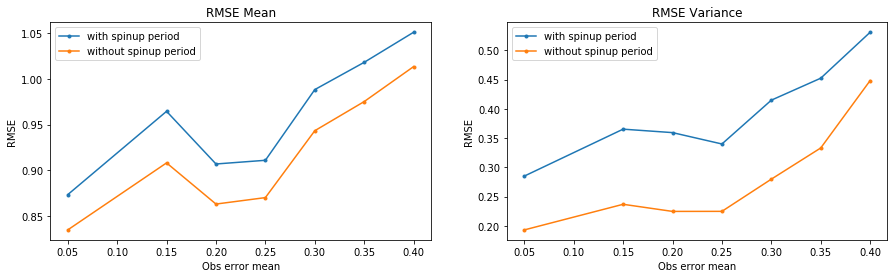

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_mean, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme bias observations

In [13]:
ex_obs_dict = pickle.load(open('./data/obs_bias_020_520.pickle', 'rb'))

obsm=0.20, Mean RMSE=0.9611, Variance RMSE=0.3433,  Without spinup: Mean RMSE=0.9226, Variance RMSE=0.2266
obsm=0.45, Mean RMSE=1.0432, Variance RMSE=0.5040,  Without spinup: Mean RMSE=1.0070, Variance RMSE=0.4076
obsm=0.70, Mean RMSE=1.2696, Variance RMSE=0.7145,  Without spinup: Mean RMSE=1.2204, Variance RMSE=0.6235
obsm=0.95, Mean RMSE=1.3249, Variance RMSE=0.6644,  Without spinup: Mean RMSE=1.2826, Variance RMSE=0.5642
obsm=1.20, Mean RMSE=1.5062, Variance RMSE=0.8736,  Without spinup: Mean RMSE=1.4665, Variance RMSE=0.7773
obsm=1.45, Mean RMSE=1.7505, Variance RMSE=0.6446,  Without spinup: Mean RMSE=1.7077, Variance RMSE=0.5196
obsm=1.70, Mean RMSE=2.0760, Variance RMSE=1.0445,  Without spinup: Mean RMSE=2.0159, Variance RMSE=0.9142
obsm=1.95, Mean RMSE=2.3987, Variance RMSE=1.6985,  Without spinup: Mean RMSE=2.3043, Variance RMSE=1.4287
obsm=2.20, Mean RMSE=2.4949, Variance RMSE=1.5502,  Without spinup: Mean RMSE=2.4246, Variance RMSE=1.3807
obsm=2.45, Mean RMSE=2.6501, Variance

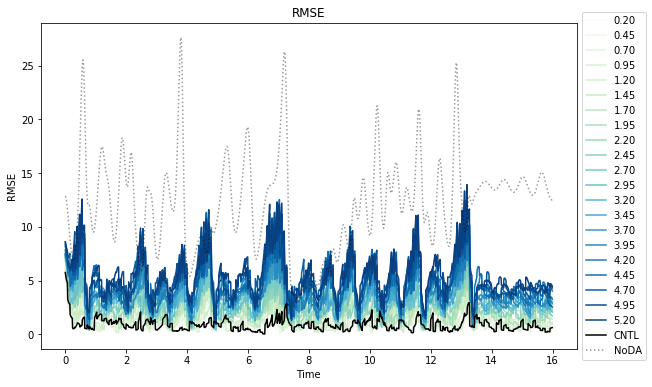

In [14]:
import matplotlib.cm as cm


mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))
colors = cm.GnBu(np.linspace(0, 1, len(ex_obs_dict.keys())))

for obsm, color in zip(ex_obs_dict.keys(), colors):
    obs = ex_obs_dict[obsm]

    hy = Hybrid3DEnVar(lorenz63_fdm, dt)
    hy.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.2,
        'inflat': 1.6,
        'beta': 0.5
    }
    hy.set_params(**params)
    hy.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(hy.analysis_3dvar, X_nature)
    print(
        f'obsm={obsm}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())
    
    plt.plot(ts, rmse, color=color, label=obsm)
    
# CNTL
plt.plot(ts, rmse_hy, color='k', label='CNTL')

# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)

ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('RMSE');

Text(0, 0.5, 'RMSE')

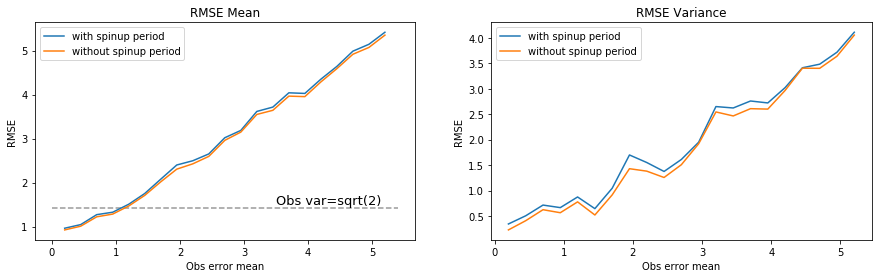

In [15]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_mean = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_mean, mean_rmse, label='with spinup period')
axs[0].plot(ex_mean, mean_rmse_nospn, label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')
axs[0].hlines(y=np.sqrt(2), xmin=0, xmax=5.4, ls='dashed', alpha=0.4)
axs[0].text(3.5, np.sqrt(2)+0.1, 'Obs var=sqrt(2)', fontsize=13)

axs[1].plot(ex_mean, var_rmse, label='with spinup period')
axs[1].plot(ex_mean, var_rmse_nospn, label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE')

# Third moment

### Assimilate skew observation based on normality test

In [16]:
ex_obs_dict = pickle.load(open('./data/obs_skew_015_135.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.15', '0.45', '0.75', '1.05', '1.35'])

alpha=0.15, Mean RMSE=0.8135, Variance RMSE=0.2901,  Without spinup: Mean RMSE=0.7828, Variance RMSE=0.2114
alpha=0.45, Mean RMSE=0.8693, Variance RMSE=0.2760,  Without spinup: Mean RMSE=0.8464, Variance RMSE=0.1794
alpha=0.75, Mean RMSE=0.9906, Variance RMSE=0.4780,  Without spinup: Mean RMSE=0.9648, Variance RMSE=0.3993
alpha=1.05, Mean RMSE=0.8326, Variance RMSE=0.3006,  Without spinup: Mean RMSE=0.7955, Variance RMSE=0.1943
alpha=1.35, Mean RMSE=0.9076, Variance RMSE=0.3550,  Without spinup: Mean RMSE=0.8733, Variance RMSE=0.2616


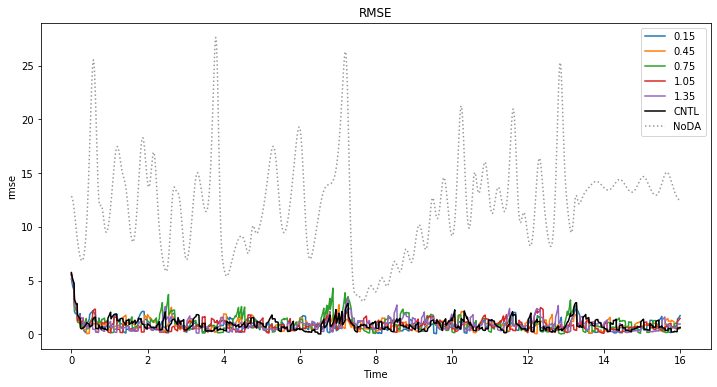

In [17]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    hy = Hybrid3DEnVar(lorenz63_fdm, dt)
    hy.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.2,
        'inflat': 1.6,
        'beta': 0.5
    }
    hy.set_params(**params)
    hy.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(hy.analysis_3dvar, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_hy, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
plt.legend()
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

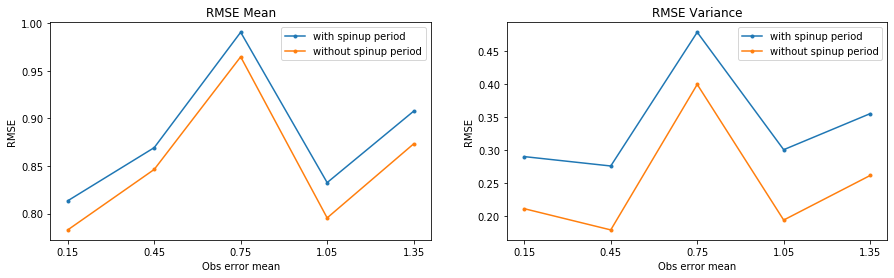

In [18]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Assimilate more extreme skewness

In [19]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

alpha=1.30, Mean RMSE=1.0258, Variance RMSE=0.4363,  Without spinup: Mean RMSE=0.9834, Variance RMSE=0.3240
alpha=1.55, Mean RMSE=0.7981, Variance RMSE=0.3358,  Without spinup: Mean RMSE=0.7618, Variance RMSE=0.1987
alpha=1.80, Mean RMSE=0.8673, Variance RMSE=0.3553,  Without spinup: Mean RMSE=0.8292, Variance RMSE=0.2536
alpha=2.05, Mean RMSE=0.8810, Variance RMSE=0.3402,  Without spinup: Mean RMSE=0.8468, Variance RMSE=0.2294
alpha=2.30, Mean RMSE=0.9407, Variance RMSE=0.4447,  Without spinup: Mean RMSE=0.8905, Variance RMSE=0.2922
alpha=2.55, Mean RMSE=0.8877, Variance RMSE=0.3404,  Without spinup: Mean RMSE=0.8682, Variance RMSE=0.2650
alpha=2.80, Mean RMSE=0.8752, Variance RMSE=0.3078,  Without spinup: Mean RMSE=0.8523, Variance RMSE=0.2237
alpha=3.05, Mean RMSE=0.9438, Variance RMSE=0.3252,  Without spinup: Mean RMSE=0.9160, Variance RMSE=0.2178
alpha=3.30, Mean RMSE=0.8617, Variance RMSE=0.3123,  Without spinup: Mean RMSE=0.8357, Variance RMSE=0.2257


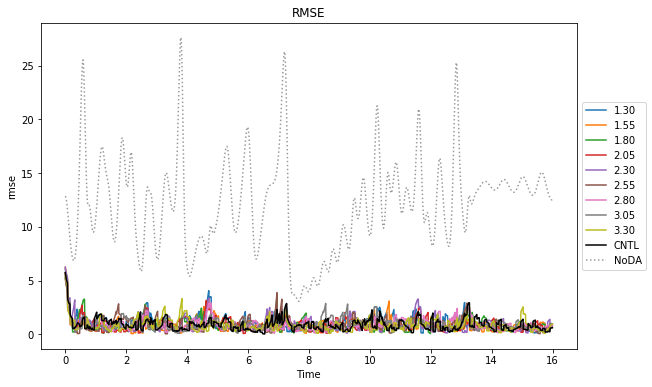

In [20]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_a in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_a]
    
    hy = Hybrid3DEnVar(lorenz63_fdm, dt)
    hy.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.2,
        'inflat': 1.6,
        'beta': 0.5
    }
    hy.set_params(**params)
    hy.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(hy.analysis_3dvar, X_nature)
    print(
        f'alpha={ex_a}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_a)
    
# CNTL
plt.plot(ts, rmse_hy, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

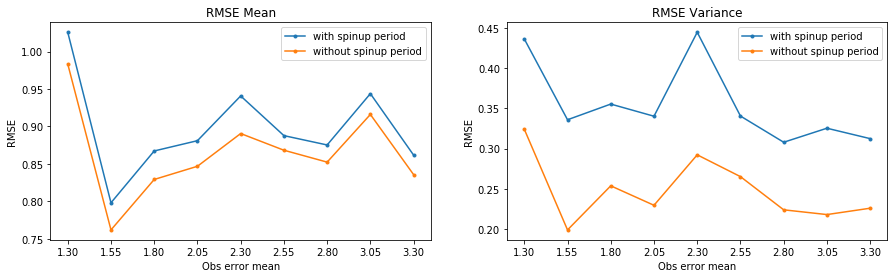

In [21]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_alpha = list(map(lambda s: float(s), ex_obs_dict.keys()))
axs[0].plot(ex_alpha, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_alpha, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(ex_alpha)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_alpha, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_alpha, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(ex_alpha)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

### Check the ratio of skew observation located bwteen -2*std ~ 2*std

In [22]:
ex_obs_dict = pickle.load(open('./data/obs_skew_130_330.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['1.30', '1.55', '1.80', '2.05', '2.30', '2.55', '2.80', '3.05', '3.30'])

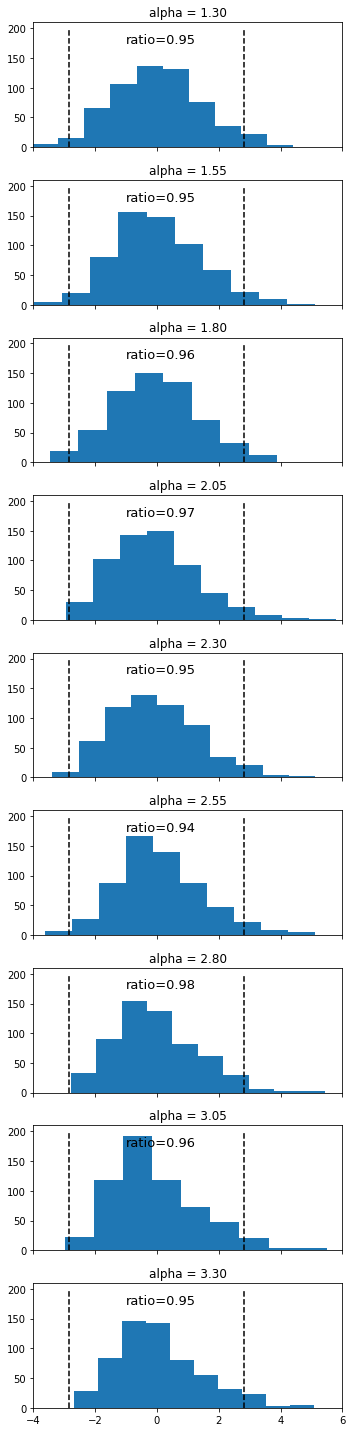

In [23]:
nrows = len(ex_obs_dict.keys())
fig, axs = plt.subplots(nrows=nrows, figsize=(5, 20), sharex=True)

for i, (key, obs) in enumerate(ex_obs_dict.items()):
    obserr = (obs - X_nature[:,::8]).ravel()
    axs[i].hist(obserr)
    
    std = np.sqrt(2)
    axs[i].vlines([2*std, -2*std], ymin=0, ymax=200, ls='dashed')
    axs[i].set_xlim([-4, 6])
    axs[i].set_title(f'alpha = {key}')
    
    total_size = obserr.size
    within_size = obserr[np.where((obserr <= 2*std) & (obserr >= -2*std))].size
    ratio = within_size / total_size
    axs[i].text(-1, 175, f'ratio={ratio:.2f}', fontsize=13)

plt.tight_layout()

# Fourth moment

### Assimilate kurtosis observation based on normality test

In [24]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_050_220.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.5', '0.6', '0.7', '0.8', '0.9', '1.2', '1.6', '1.8', '2.0', '2.2'])

delta=0.5, Mean RMSE=0.8195, Variance RMSE=0.3080,  Without spinup: Mean RMSE=0.7892, Variance RMSE=0.2185
delta=0.6, Mean RMSE=0.9159, Variance RMSE=0.4393,  Without spinup: Mean RMSE=0.8701, Variance RMSE=0.2925
delta=0.7, Mean RMSE=1.0084, Variance RMSE=0.4825,  Without spinup: Mean RMSE=0.9504, Variance RMSE=0.3298
delta=0.8, Mean RMSE=0.8885, Variance RMSE=0.2973,  Without spinup: Mean RMSE=0.8590, Variance RMSE=0.2121
delta=0.9, Mean RMSE=0.8951, Variance RMSE=0.3110,  Without spinup: Mean RMSE=0.8571, Variance RMSE=0.1809
delta=1.2, Mean RMSE=0.9072, Variance RMSE=0.3597,  Without spinup: Mean RMSE=0.8742, Variance RMSE=0.2357
delta=1.6, Mean RMSE=0.9246, Variance RMSE=0.3196,  Without spinup: Mean RMSE=0.8969, Variance RMSE=0.2193
delta=1.8, Mean RMSE=0.9012, Variance RMSE=0.3420,  Without spinup: Mean RMSE=0.8654, Variance RMSE=0.2600
delta=2.0, Mean RMSE=0.9417, Variance RMSE=0.3421,  Without spinup: Mean RMSE=0.8967, Variance RMSE=0.2290
delta=2.2, Mean RMSE=0.9593, Variance

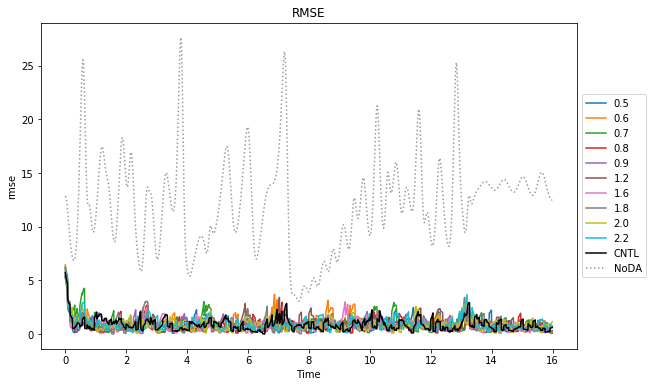

In [25]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    hy = Hybrid3DEnVar(lorenz63_fdm, dt)
    hy.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.2,
        'inflat': 1.6,
        'beta': 0.5
    }
    hy.set_params(**params)
    hy.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(hy.analysis_3dvar, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_hy, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

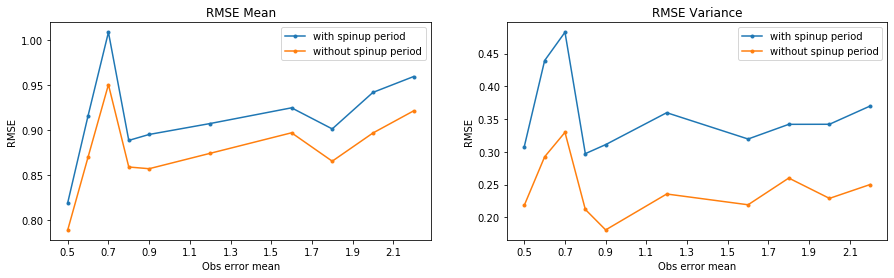

In [26]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta, mean_rmse, '.-', label='with spinup period')
axs[0].plot(ex_delta, mean_rmse_nospn, '.-', label='without spinup period')
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta, var_rmse, '.-', label='with spinup period')
axs[1].plot(ex_delta, var_rmse_nospn, '.-', label='without spinup period')
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

(-20, 20)

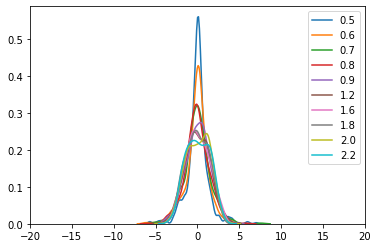

In [27]:
import seaborn as sns

fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20])

### Assimilate kurtosis observation with more extreme delta

In [28]:
ex_obs_dict = pickle.load(open('./data/obs_kurtosis_010_340.pickle', 'rb'))
ex_obs_dict.keys()

dict_keys(['0.1', '0.2', '0.3', '0.4', '2.5', '2.8', '3.1', '3.4'])

delta=0.1, Mean RMSE=0.4872, Variance RMSE=0.2216,  Without spinup: Mean RMSE=0.4431, Variance RMSE=0.0914
delta=0.2, Mean RMSE=0.7403, Variance RMSE=0.5992,  Without spinup: Mean RMSE=0.7038, Variance RMSE=0.5029
delta=0.3, Mean RMSE=0.8190, Variance RMSE=0.5793,  Without spinup: Mean RMSE=0.7741, Variance RMSE=0.4471
delta=0.4, Mean RMSE=0.7934, Variance RMSE=0.3486,  Without spinup: Mean RMSE=0.7474, Variance RMSE=0.2364
delta=2.5, Mean RMSE=0.9380, Variance RMSE=0.2790,  Without spinup: Mean RMSE=0.9026, Variance RMSE=0.1825
delta=2.8, Mean RMSE=0.8349, Variance RMSE=0.3118,  Without spinup: Mean RMSE=0.8056, Variance RMSE=0.2168
delta=3.1, Mean RMSE=0.8481, Variance RMSE=0.3047,  Without spinup: Mean RMSE=0.8189, Variance RMSE=0.2070
delta=3.4, Mean RMSE=0.9007, Variance RMSE=0.2922,  Without spinup: Mean RMSE=0.8686, Variance RMSE=0.2082


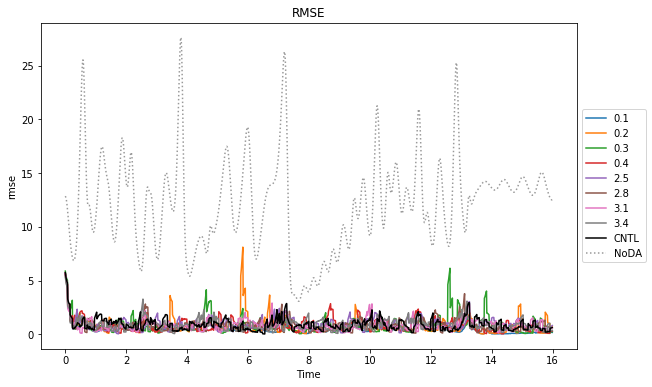

In [29]:
mean_rmse = []        # mean RMSE
mean_rmse_nospn = []  # mean RMSE without spin up periods
var_rmse = []
var_rmse_nospn = []

plt.figure(figsize=(12, 6))

for ex_d in ex_obs_dict.keys():
    obs = ex_obs_dict[ex_d]
    
    hy = Hybrid3DEnVar(lorenz63_fdm, dt)
    hy.list_params()
    params = {
        'X_ini': X_ini,
        'X_ens_ini': X_ens_ini,
        'obs': obs,
        'obs_interv': 8,
        'Pb': Pb,
        'R': R,
        'H_func': lambda arr: arr,
        'H': np.eye(3),
        'alpha': 0.2,
        'inflat': 1.6,
        'beta': 0.5
    }
    hy.set_params(**params)
    hy.cycle()

    # calculate RMSE and stable index
    rmse = RMSE(hy.analysis_3dvar, X_nature)
    print(
        f'delta={ex_d}, Mean RMSE={rmse.mean():.4f}, Variance RMSE={rmse.var():.4f},  '
        + f'Without spinup: Mean RMSE={rmse[50:].mean():.4f}, Variance RMSE={rmse[50:].var():.4f}'
    )
    mean_rmse.append(rmse.mean())
    mean_rmse_nospn.append(rmse[50:].mean())
    var_rmse.append(rmse.var())
    var_rmse_nospn.append(rmse[50:].var())

    plt.plot(ts, rmse, label=ex_d)
    
# CNTL
plt.plot(ts, rmse_hy, color='k', label='CNTL')
    
# no DA
forecast = lorenz63_fdm(X_ini, ts)
rmse_noda = RMSE(forecast, X_nature)
plt.plot(ts, rmse_noda, label='NoDA', color='k', ls='dotted', alpha=0.4)
    
ax = plt.gca()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('RMSE')
plt.xlabel('Time')
plt.ylabel('rmse');

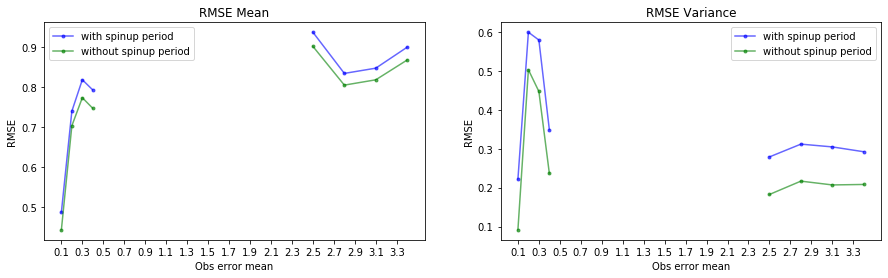

In [30]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 4))

ex_delta = list(map(lambda s: float(s), ex_obs_dict.keys()))
xticks = np.arange(min(ex_delta), max(ex_delta), 0.2)

axs[0].plot(ex_delta[:4], mean_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[0].plot(ex_delta[4:], mean_rmse[4:], 'b.-', alpha=0.6)
axs[0].plot(ex_delta[:4], mean_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[0].plot(ex_delta[4:], mean_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[0].legend()
axs[0].set_title('RMSE Mean')
axs[0].set_xticks(xticks)
axs[0].set_xlabel('Obs error mean')
axs[0].set_ylabel('RMSE')

axs[1].plot(ex_delta[:4], var_rmse[:4], 'b.-', alpha=0.6, label='with spinup period')
axs[1].plot(ex_delta[4:], var_rmse[4:], 'b.-', alpha=0.6)
axs[1].plot(ex_delta[:4], var_rmse_nospn[:4], 'g.-', alpha=0.6, label='without spinup period')
axs[1].plot(ex_delta[4:], var_rmse_nospn[4:], 'g.-', alpha=0.6)
axs[1].legend()
axs[1].set_title('RMSE Variance')
axs[1].set_xticks(xticks)
axs[1].set_xlabel('Obs error mean')
axs[1].set_ylabel('RMSE');

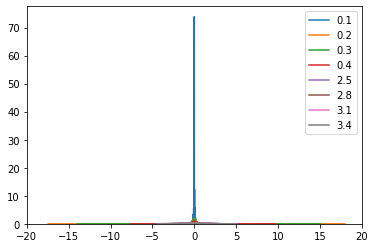

In [31]:
fig, ax = plt.subplots()

for key in ex_obs_dict.keys():
    obs = ex_obs_dict[key]
    obserr = obs - X_nature[:,::8]
    obserr = obserr.ravel()
    sns.kdeplot(obserr, label=key, ax=ax)
plt.xlim([-20, 20]);